# 모듈 임포트 및 데이터 로드

In [1]:
from tqdm.auto import tqdm
import random
import os

import torch
import pymysql

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import numpy as np
import pandas as pd

from datetime import datetime

In [2]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
import FinanceDataReader as fdr

In [5]:
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,77800,2,-200,-0.26,77700,78200,77500,10201589,794246992900,464449082390000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,141000,1,600,0.43,140900,141500,139500,1305470,183176874900,102648333465000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,423500,1,2500,0.59,421500,424500,421000,98834,41796288000,99099000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,753000,1,24000,3.29,729000,760000,727000,96211,71944057000,53594022000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,61700,2,-100,-0.16,61800,61900,61400,615499,37960041400,50772109390000,822886700,STK


In [6]:
df_kospi = df_krx[df_krx['Market'] == 'KOSPI']
df_kospi

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,77800,2,-200,-0.26,77700,78200,77500,10201589,794246992900,464449082390000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,141000,1,600,0.43,140900,141500,139500,1305470,183176874900,102648333465000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,423500,1,2500,0.59,421500,424500,421000,98834,41796288000,99099000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,753000,1,24000,3.29,729000,760000,727000,96211,71944057000,53594022000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,61700,2,-100,-0.16,61800,61900,61400,615499,37960041400,50772109390000,822886700,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,002785,KR7002781003,진흥기업우B,KOSPI,,4670,3,0,0.00,4630,4670,4605,20,92790,4003208060,857218,STK
2771,000227,KR7000222000,유유제약2우B,KOSPI,,12160,1,660,5.74,11760,12400,11650,11006,133344220,3958809600,325560,STK
2774,002787,KR7002782001,진흥기업2우B,KOSPI,,12750,1,270,2.16,12700,12750,12700,82,1045100,3758802000,294808,STK
2775,001525,KR7001521004,동양우,KOSPI,,6050,1,50,0.83,6130,6130,6050,605,3635530,3737272550,617731,STK


In [7]:
def get_stock_data(item_name, year=2030):
    df_krx = fdr.StockListing('KRX')
    df_kospi = df_krx[df_krx['Market'] == 'KOSPI']

    def item_code_by_item_name(item_name):
        item_code_list = df_kospi.loc[df_kospi["Name"] == item_name, "Code"].tolist()
        if len(item_code_list) > 0:
            item_code = item_code_list[0]
            return item_code
        else:
            return None

    def find_item_list(item_name, year=2023):
        item_code = item_code_by_item_name(item_name)
        if item_code:
            df_day = fdr.DataReader(item_code, str(year))
            return df_day
        else:
            return None

    df = find_item_list(item_name, year)
    return df

# 모델 세팅 및 학습, 예측

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
def preprocess_data(df):
    data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

def train_prophet_model(df, days_to_predict):
    df['ds'] = pd.to_datetime(df.index)
    df['y'] = df['Close']

    # 주말을 제외한 사용자 정의 휴일 데이터프레임 생성
    holidays = pd.DataFrame({
        'holiday': 'weekday',
        'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='B')
    })

    model = Prophet(daily_seasonality=True, holidays=holidays)
    model.fit(df[['ds', 'y']])

    # 'B' 주기를 사용하여 평일만 예측하도록 future 데이터프레임 생성
    future = model.make_future_dataframe(periods=days_to_predict, freq='B')
    forecast = model.predict(future)

    # 실제값과 예측값 추출
    y_true = df['y']
    y_pred = forecast['yhat'][:-days_to_predict]  # 예측값 중에서 실제값과 대응되는 부분만 선택

    # MAE와 MSE 계산
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')

    return model, forecast

def plot_prophet_forecast(model, forecast):
    model.plot(forecast)
    plt.show()

def save_forecast_to_dataframe(df, forecast, stock_name):
    forecast_df = forecast[['ds', 'yhat']].tail(14).rename(columns={'ds': 'Date', 'yhat': 'Predicted_Close'})
    forecast_df['Stock'] = stock_name
    return forecast_df

In [25]:
get_stock_data("삼성전자", year=2023)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.003617
2023-01-03,55400,56000,54500,55400,13547030,-0.001802
2023-01-04,55700,58000,55600,57800,20188071,0.043321
2023-01-05,58200,58800,57600,58200,15682826,0.006920
2023-01-06,58300,59400,57900,59000,17334989,0.013746
...,...,...,...,...,...,...
2023-12-21,74600,75000,74300,75000,13478766,0.002674
2023-12-22,75800,76300,75400,75900,14515608,0.012000
2023-12-26,76100,76700,75700,76600,13164909,0.009223


13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 1124.5365119450032
Mean Squared Error (MSE): 1930672.665759306


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


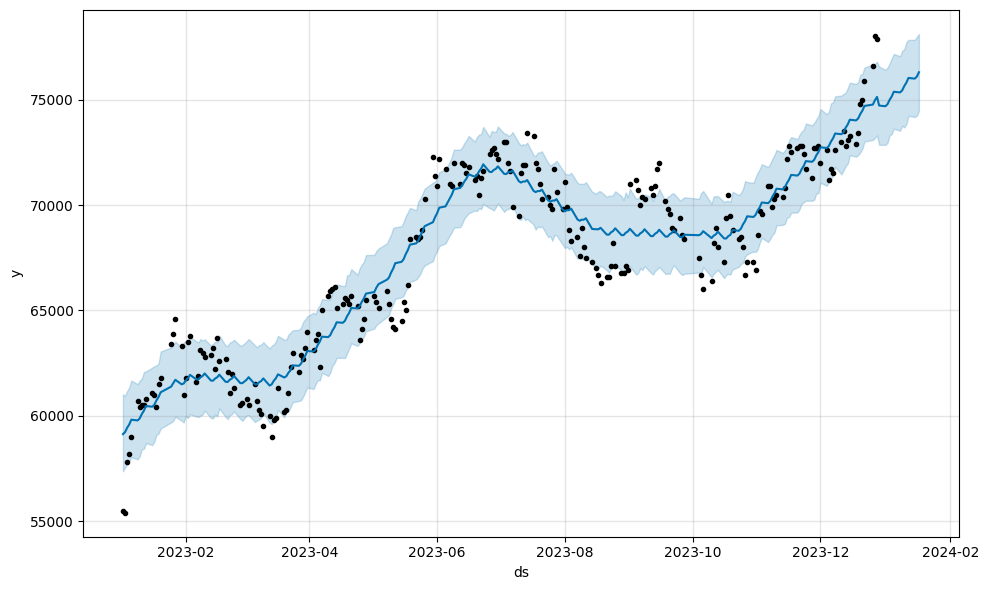

13:50:51 - cmdstanpy - INFO - Chain [1] start processing
13:50:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 3913.8145864643043
Mean Squared Error (MSE): 22806275.905990202


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


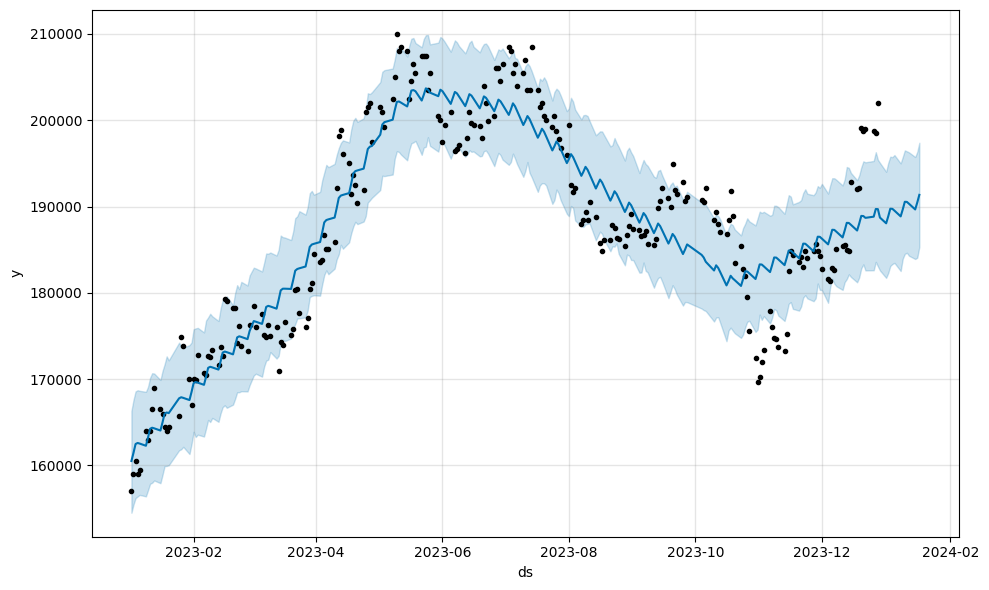

13:51:01 - cmdstanpy - INFO - Chain [1] start processing
13:51:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 19849.863571991336
Mean Squared Error (MSE): 610126725.4547625


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


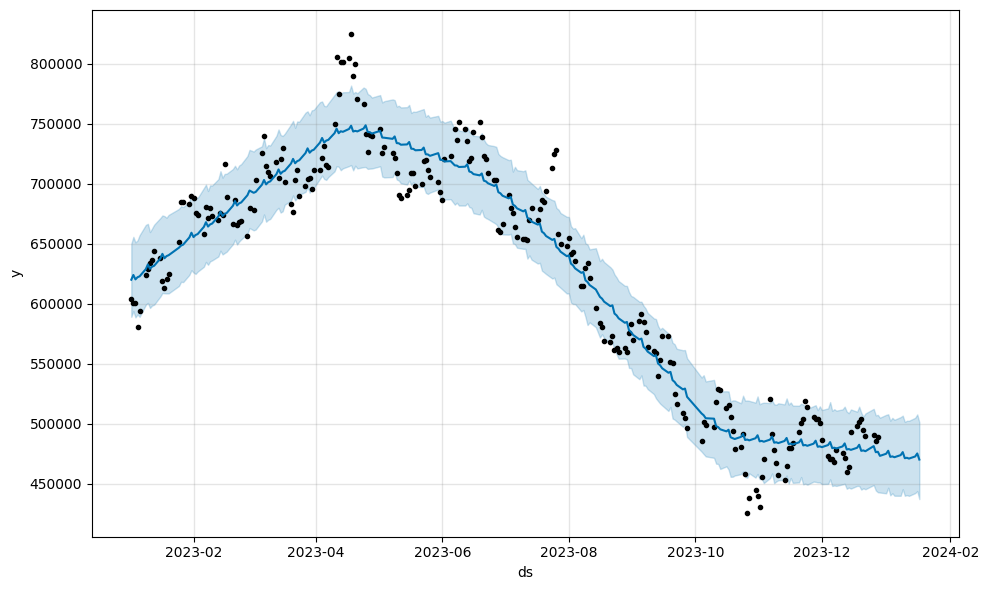

13:51:18 - cmdstanpy - INFO - Chain [1] start processing
13:51:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 12145.006778991687
Mean Squared Error (MSE): 241908206.75377


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


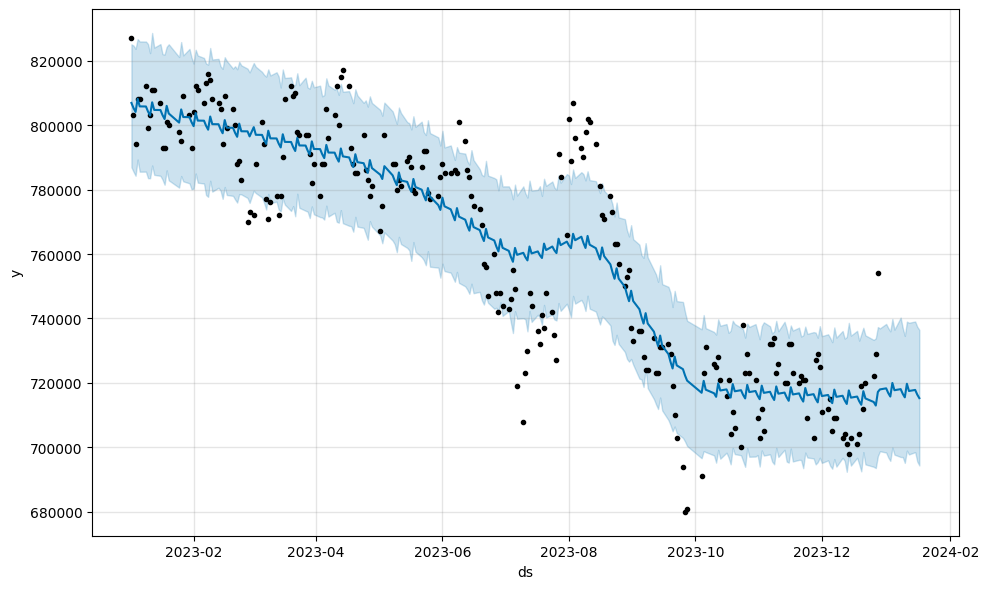

In [10]:
# 예측을 위한 주식 종목 리스트
stock_list = ["삼성전자", "현대차", "LG화학", "POSCO", "삼성바이오로직스"]

forecast_list = []

# 모든 주식 종목에 대한 예측 수행
for stock in stock_list:
    df_stock = get_stock_data(stock, year=2023)
    if df_stock is not None:
        scaled_data = preprocess_data(df_stock)

        # Train Prophet model
        model, forecast = train_prophet_model(df_stock, days_to_predict=14)

        # Plot forecast
        plot_prophet_forecast(model, forecast)

        # Save forecast to dataframe
        forecast_df = save_forecast_to_dataframe(df_stock, forecast, stock)
        forecast_list.append(forecast_df)

In [11]:
import pandas as pd

In [12]:
forecast_list2=forecast_list.copy()

In [13]:
forecast_list2

[          Date  Predicted_Close Stock
 245 2023-12-29     74722.735289  삼성전자
 246 2024-01-01     74689.874961  삼성전자
 247 2024-01-02     74785.332151  삼성전자
 248 2024-01-03     74993.036206  삼성전자
 249 2024-01-04     75150.738605  삼성전자
 250 2024-01-05     75377.314790  삼성전자
 251 2024-01-08     75344.454462  삼성전자
 252 2024-01-09     75439.911652  삼성전자
 253 2024-01-10     75647.615707  삼성전자
 254 2024-01-11     75805.318106  삼성전자
 255 2024-01-12     76031.894290  삼성전자
 256 2024-01-15     75999.033962  삼성전자
 257 2024-01-16     76094.491152  삼성전자
 258 2024-01-17     76302.195207  삼성전자,
           Date  Predicted_Close Stock
 245 2023-12-29    188723.839597   현대차
 246 2024-01-01    188059.727782   현대차
 247 2024-01-02    188862.781652   현대차
 248 2024-01-03    189751.269271   현대차
 249 2024-01-04    189735.942648   현대차
 250 2024-01-05    189526.326858   현대차
 251 2024-01-08    188862.215043   현대차
 252 2024-01-09    189665.268914   현대차
 253 2024-01-10    190553.756532   현대차
 254 2024-01-11    19053

In [26]:
forecast_list[0]

,Date,Predicted_Close,Stock
245,2023-12-29,74722.735289,삼성전자
246,2024-01-01,74689.874961,삼성전자
247,2024-01-02,74785.332151,삼성전자
248,2024-01-03,74993.036206,삼성전자
249,2024-01-04,75150.738605,삼성전자
250,2024-01-05,75377.314790,삼성전자
251,2024-01-08,75344.454462,삼성전자
252,2024-01-09,75439.911652,삼성전자
253,2024-01-10,75647.615707,삼성전자
254,2024-01-11,75805.318106,삼성전자


In [15]:
send_data = []
for forecast in forecast_list:
    # forecast['Stock']이 Series나 DataFrame 열일 경우 첫 번째 값을 문자열로 추출
    stock_name = forecast['Stock']
    if isinstance(stock_name, pd.Series) or isinstance(stock_name, pd.DataFrame):
        stock_name = stock_name.iloc[0]

    # df_krx DataFrame에서 해당 주식 이름에 맞는 'Code'를 찾음
    matched_code = df_krx.loc[df_krx['Name'] == stock_name, 'Code']
    
    # 해당하는 코드가 없으면 오류를 방지하기 위해 기본값 설정
    stock_code = matched_code.iloc[0] if not matched_code.empty else None

    if stock_code:
        today_date = datetime.now().strftime('%Y-%m-%d')

        # 예측 데이터 처리 및 DataFrame 생성
        data = {
            'code': stock_code,
            'name': stock_name,
            'date': today_date,
            'day1': int(forecast['Predicted_Close'].iloc[0]),
            'day2': int(forecast['Predicted_Close'].iloc[1]),
            'day3': int(forecast['Predicted_Close'].iloc[2]),
            'day4': int(forecast['Predicted_Close'].iloc[3]),
            'day5': int(forecast['Predicted_Close'].iloc[4]),
            'day6': int(forecast['Predicted_Close'].iloc[5]),
            'day7': int(forecast['Predicted_Close'].iloc[6]),
            'day8': int(forecast['Predicted_Close'].iloc[7]),
            'day9': int(forecast['Predicted_Close'].iloc[8]),
            'day10': int(forecast['Predicted_Close'].iloc[9])
        }
        send_data.append(data)


In [16]:
type(send_data[1]['code'])

str

In [17]:
conn = pymysql.connect(host='localhost', user='urstory', password='u1234', db='miniprojectdb', charset='utf8')

In [18]:
cur = conn.cursor()

In [19]:
# 최초에 table 형성할때 한번만 실행하면 OK

sql= '''create table predict (
    id int not null AUTO_INCREMENT COMMENT '기본키',
    code varchar(30) not null COMMENT '주식 코드',
    name varchar(30) not null COMMENT '주식 이름',
    date DATE not null COMMENT '예측 일자',
    day1 int not null COMMENT '예측 종가',
    day2 int not null COMMENT '예측 종가',
    day3 int not null COMMENT '예측 종가',
    day4 int not null COMMENT '예측 종가',
    day5 int not null COMMENT '예측 종가',
    day6 int not null COMMENT '예측 종가',
    day7 int not null COMMENT '예측 종가',
    day8 int not null COMMENT '예측 종가',
    day9 int not null COMMENT '예측 종가',
    day10 int not null COMMENT '예측 종가',
	PRIMARY KEY(id),
    UNIQUE KEY(code, date)
);
'''
cur.execute(sql)

OperationalError: (1050, "Table 'predict' already exists")

In [ ]:
insert_sql = '''
INSERT INTO predict (code, name, date, day1, day2, day3, day4, day5, day6, day7, day8, day9, day10)
VALUES (%s, %s, %s, %d, %d, %d, %d, %d, %d, %d, %d, %d, %d)
'''

for data in send_data:
    # 데이터 변환 및 삽입 로직
    values = [
        data['code'],
        data['name'],
        data['date'],  # 예측 일자
        data['day1'],
        data['day2'],
        data['day3'],
        data['day4'],
        data['day5'],
        data['day6'],
        data['day7'],
        data['day8'],
        data['day9'],
        data['day10']
    ]
    cur.executemany(insert_sql, values)

TypeError: not enough arguments for format string

In [ ]:
# send_data= []
# for i in range(len(forecast_list)):
#     forecast_list2[i]['Predicted_Close']=(forecast_list[i]['Predicted_Close']/100).round()*100
#     forecast_list2[i]['Code'] = (df_krx['Code'].loc[df_krx['Name'] == (forecast_list[i]['Stock'].head(1).values[0])]).values[0]
#     data = pd.DataFrame([])
#     data['code']=forecast_list2[i]['Code'].head(1)
#     data['name']=forecast_list2[i]['Stock'].head(1)
#     data['date']=datetime()
#     data[['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10']]=list(map(int,list(forecast_list2[i].head(10)['Predicted_Close'])))
#     data=data.reset_index(drop=True)
#     send_data.append(data)

k=0
for i in range(len(send_data)):
    sql = f'''INSERT INTO predict (code, name, day1, day2, day3, day4, day5, day6, day7, day8, day9, day10) 
VALUES ('{send_data[i]['code'][k]}','{send_data[i]['name'][k]}','{send_data[i]['date'][k]}', {send_data[i]['day1'][k]}, {send_data[i]['day2'][k]}, {send_data[i]['day3'][k]},{send_data[i]['day4'][k]}, {send_data[i]['day5'][k]}, {send_data[i]['day6'][k]}, {send_data[i]['day7'][k]}, {send_data[i]['day8'][k]}, {send_data[i]['day9'][k]}, {send_data[i]['day10'][k]});
          '''
    print(sql)
    cur.execute(sql)
    conn.commit()


TypeError: 'int' object is not subscriptable